<!--- Licensed to the Apache Software Foundation (ASF) under one -->
<!--- or more contributor license agreements.  See the NOTICE file -->
<!--- distributed with this work for additional information -->
<!--- regarding copyright ownership.  The ASF licenses this file -->
<!--- to you under the Apache License, Version 2.0 (the -->
<!--- "License"); you may not use this file except in compliance -->
<!--- with the License.  You may obtain a copy of the License at -->

<!---   http://www.apache.org/licenses/LICENSE-2.0 -->

<!--- Unless required by applicable law or agreed to in writing, -->
<!--- software distributed under the License is distributed on an -->
<!--- "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY -->
<!--- KIND, either express or implied.  See the License for the -->
<!--- specific language governing permissions and limitations -->
<!--- under the License. -->

# Step 6: Train a Neural Network

Now that you have seen all the necessary components for creating a neural network, you are
now ready to put all the pieces together and train a model end to end.

## 1. Data preparation

The typical process for creating and training a model starts with loading and
preparing the datasets. For this Network you will use a [dataset of leaf
images](https://data.mendeley.com/datasets/hb74ynkjcn/1) that consists of healthy
and diseased examples of leafs from twelve different plant species. To get this
dataset you have to download and extract it with the following commands.

In [1]:
# Import all the necessary libraries to train
import time
import os
import zipfile

import mxnet as mx
from mxnet import np, npx, gluon, init, autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

from prepare_dataset import process_dataset #utility code to rearrange the data

mx.np.random.seed(42)

In [2]:
# Download dataset
url = 'https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/hb74ynkjcn-1.zip'
zip_file_path = mx.gluon.utils.download(url)

os.makedirs('plants', exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zf:
    zf.extractall('plants')

os.remove(zip_file_path)

#### Data inspection

If you take a look at the dataset you find the following structure for the directories:

```
plants
|-- Alstonia Scholaris (P2)
|-- Arjun (P1)
|-- Bael (P4)
    |-- diseased
        |-- 0016_0001.JPG
        |-- .
        |-- .
        |-- .
        |-- 0016_0118.JPG
|-- .
|-- .
|-- .
|-- Mango (P0)
    |-- diseased
    |-- healthy
```


Each plant species has its own directory, for each of those directories you might
find subdirectories with examples of diseased leaves, healthy
leaves, or both. With this dataset you can formulate different classification
problems; for example, you can create a multi-class classifier that determines
the species of a plant based on the leaves; you can instead create a binary
classifier that tells you whether the plant is healthy or diseased. Additionally, you can create
a multi-class, multi-label classifier that tells you both: what species a
plant is and whether the plant is diseased or healthy. In this example you will stick to
the simplest classification question, which is whether a plant is healthy or not.

To do this, you need to manipulate the dataset in two ways. First, you need to
combine all images with labels consisting of healthy and diseased, regardless of the species, and then you
need to split the data into train, validation, and test sets. We prepared a
small utility script that does this to get the dataset ready for you.
Once you run this utility code on the data, the structure will be
already organized in folders containing the right images in each of the classes,
you can use the `ImageFolderDataset` class to import the images from the file to MXNet.

In [3]:
# Call the utility function to rearrange the images
process_dataset('plants')

The dataset is located in the `datasets` folder and the new structure
looks like this:

```
datasets
|-- test
    |-- diseased
    |-- healthy
|-- train
|-- validation
    |-- diseased
    |-- healthy
        |-- image1.JPG
        |-- image2.JPG
        |-- .
        |-- .
        |-- .
        |-- imagen.JPG
```


Now, you need to create three different Dataset objects from the `train`,
`validation`, and `test` folders, and the `ImageFolderDataset` class takes
care of inferring the classes from the directory names. If you don't remember
how the `ImageFolderDataset` works, take a look at [Step 5](5-datasets.md)
of this course for a deeper description.

In [4]:
# Use ImageFolderDataset to create a Dataset object from directory structure
train_dataset = gluon.data.vision.ImageFolderDataset('./datasets/train')
val_dataset = gluon.data.vision.ImageFolderDataset('./datasets/validation')
test_dataset = gluon.data.vision.ImageFolderDataset('./datasets/test')

The result from this operation is a different Dataset object for each folder.
These objects hold a collection of images and labels and as such they can be
indexed, to get the $i$-th element from the dataset. The $i$-th element is a
tuple with two objects, the first object of the tuple is the image in array
form and the second is the corresponding label for that image.

[09:09:18] /work/mxnet/src/storage/storage.cc:199: Using Pooled (Naive) StorageManager for CPU


Data type: uint8
Label: 0
Label description: diseased
Image shape: (4000, 6000, 3)


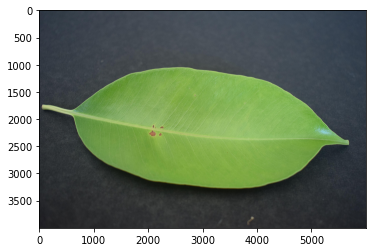

In [5]:
sample_idx = 888 # choose a random sample
sample = train_dataset[sample_idx]
data = sample[0]
label = sample[1]

plt.imshow(data.asnumpy())
print(f"Data type: {data.dtype}")
print(f"Label: {label}")
print(f"Label description: {train_dataset.synsets[label]}")
print(f"Image shape: {data.shape}")

As you can see from the plot, the image size is very large 4000 x 6000 pixels.
Usually, you downsize images before passing them to a neural network to reduce the training time.
It is also customary to make slight modifications to the images to improve generalization. That is why you add
transformations to the data in a process called Data Augmentation.

You can augment data in MXNet using `transforms`. For a complete list of all
the available transformations in MXNet check out
[available transforms](../../../api/gluon/data/vision/transforms/index.rst).
It is very common to use more than one transform per image, and it is also
common to process transforms sequentially. To this end, you can use the `transforms.Compose` class.
This class is very useful to create a transformation pipeline for your images.

You have to compose two different transformation pipelines, one for training
and the other one for validating and testing. This is because each pipeline
serves different pursposes. You need to downsize, convert to tensor and normalize
images across all the different datsets; however, you typically do not want to randomly flip
or add color jitter to the validation or test images since you could reduce performance.

In [6]:
# Import transforms as compose a series of transformations to the images
from mxnet.gluon.data.vision import transforms

jitter_param = 0.05

# mean and std for normalizing image value in range (0,1)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

training_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.RandomFlipLeftRight(),
    transforms.RandomColorJitter(contrast=jitter_param),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

validation_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

With your augmentations ready, you can create the `DataLoaders` to use them. To
do this the `gluon.data.DataLoader` class comes in handy. You have to pass the dataset with
the applied transformations (notice the `.transform_first()` method on the datasets)
to `gluon.data.DataLoader`. Additionally, you need to decide the batch size,
which is how many images you will be passing to the network,
and whether you want to shuffle the dataset.

In [7]:
# Create data loaders
batch_size = 4
train_loader = gluon.data.DataLoader(train_dataset.transform_first(training_transformer),
                                     batch_size=batch_size,
                                     shuffle=True,
                                     try_nopython=True)
validation_loader = gluon.data.DataLoader(val_dataset.transform_first(validation_transformer),
                                          batch_size=batch_size,
                                          try_nopython=True)
test_loader = gluon.data.DataLoader(test_dataset.transform_first(validation_transformer),
                                    batch_size=batch_size,
                                    try_nopython=True)

Now, you can inspect the transformations that you made to the images. A prepared
utility function has been provided for this.

In [8]:
# Function to plot batch
def show_batch(batch, columns=4, fig_size=(9, 5), pad=1):
    labels = batch[1].asnumpy()
    batch = batch[0] / 2 + 0.5     # unnormalize
    batch = np.clip(batch.asnumpy(), 0, 1) # clip values
    size = batch.shape[0]
    rows = int(size / columns)
    fig, axes = plt.subplots(rows, columns, figsize=fig_size)
    for ax, img, label in zip(axes.flatten(), batch, labels):
        ax.imshow(np.transpose(img, (1, 2, 0)))
        ax.set(title=f"Label: {label}")
    fig.tight_layout(h_pad=pad, w_pad=pad)
    plt.show()

In [9]:
for batch in train_loader:
    a = batch
    break

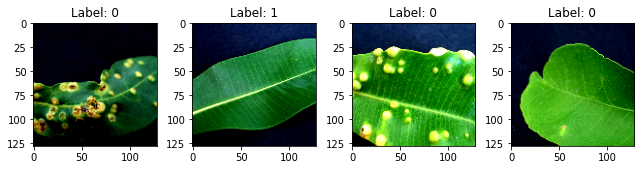

In [10]:
show_batch(a)

You can see that the original images changed to have different sizes and variations
in color and lighting. These changes followed the specified transformations you stated
in the pipeline. You are now ready to go to the next step: **Create the
architecture**.

## 2. Create Neural Network

Convolutional neural networks are a great tool to capture the spatial
relationship of pixel values within images, for this reason they have become the
gold standard for computer vision. In this example you will create a small convolutional neural
network using what you learned from [Step 2](2-create-nn.md) of this crash course series.
First, you can set up two functions that will generate the two types of blocks
you intend to use, the convolution block and the dense block. Then you can create an
entire network based on these two blocks using a custom class.

In [11]:
# The convolutional block has a convolution layer, a max pool layer and a batch normalization layer
def conv_block(filters, kernel_size=2, stride=2, batch_norm=True):
    conv_block = nn.HybridSequential()
    conv_block.add(nn.Conv2D(channels=filters, kernel_size=kernel_size, activation='relu'),
              nn.MaxPool2D(pool_size=4, strides=stride))
    if batch_norm:
        conv_block.add(nn.BatchNorm())
    return conv_block

# The dense block consists of a dense layer and a dropout layer
def dense_block(neurons, activation='relu', dropout=0.2):
    dense_block = nn.HybridSequential()
    dense_block.add(nn.Dense(neurons, activation=activation))
    if dropout:
        dense_block.add(nn.Dropout(dropout))
    return dense_block

In [12]:
# Create neural network blueprint using the blocks
class LeafNetwork(nn.HybridBlock):
    def __init__(self):
        super(LeafNetwork, self).__init__()
        self.conv1 = conv_block(32)
        self.conv2 = conv_block(64)
        self.conv3 = conv_block(128)
        self.flatten = nn.Flatten()
        self.dense1 = dense_block(100)
        self.dense2 = dense_block(10)
        self.dense3 = nn.Dense(2)

    def forward(self, batch):
        batch = self.conv1(batch)
        batch = self.conv2(batch)
        batch = self.conv3(batch)
        batch = self.flatten(batch)
        batch = self.dense1(batch)
        batch = self.dense2(batch)
        batch = self.dense3(batch)

        return batch

You have concluded the architecting part of the network, so now you can actually
build a model from that architecture for training. As you have seen
previously on [Step 4](4-components.md) of this
crash course series, to use the network you need to initialize the parameters and
hybridize the model.

In [13]:
# Create the model based on the blueprint provided and initialize the parameters
ctx = mx.gpu()

initializer = mx.initializer.Xavier()

model = LeafNetwork()
model.initialize(initializer, ctx=ctx)
model.summary(mx.np.random.uniform(size=(4, 3, 128, 128), ctx=ctx))
model.hybridize()

[09:09:23] /work/mxnet/src/storage/storage.cc:199: Using Pooled (Naive) StorageManager for GPU


--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                            (4, 3, 128, 128)               0
        Activation-1                           (4, 32, 127, 127)               0
            Conv2D-2                           (4, 32, 127, 127)             416
         MaxPool2D-3                             (4, 32, 62, 62)               0
         BatchNorm-4                             (4, 32, 62, 62)             128
        Activation-5                             (4, 64, 61, 61)               0
            Conv2D-6                             (4, 64, 61, 61)            8256
         MaxPool2D-7                             (4, 64, 29, 29)               0
         BatchNorm-8                             (4, 64, 29, 29)             256
        Activation-9                            (4, 128, 28, 28)               0
           Conv2D-10        

[09:09:25] /work/mxnet/src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:97: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)


## 3. Choose Optimizer and Loss function

With the network created you can move on to choosing an optimizer and a loss
function. The network you created uses these components to make an informed decision on how
to tune the parameters to fit the final objective better. You can use the `gluon.Trainer` class to
help with optimizing these parameters. The `gluon.Trainer` class needs two things to work
properly: the parameters needing to be tuned and the optimizer with its
corresponding hyperparameters. The trainer uses the error reported by the loss
function to optimize these parameters.

For this particular dataset you will use Stochastic Gradient Descent as the
optimizer and Cross Entropy as the loss function.

In [14]:
# SGD optimizer
optimizer = 'sgd'

# Set parameters
optimizer_params = {'learning_rate': 0.001}

# Define the trainer for the model
trainer = gluon.Trainer(model.collect_params(), optimizer, optimizer_params)

# Define the loss function
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()

Finally, you have to set up the training loop, and you need to create a function to evaluate the performance of the network on the validation dataset.

In [15]:
# Function to return the accuracy for the validation and test set
def test(val_data):
    acc = gluon.metric.Accuracy()
    for batch in val_data:
        data = batch[0]
        labels = batch[1]
        outputs = model(data.as_in_ctx(ctx))
        acc.update([labels], [outputs])

    _, accuracy = acc.get()
    return accuracy

## 4. Training Loop

Now that you have everything set up, you can start training your network. This might
take some time to train depending on the hardware, number of layers, batch size and
images you use. For this particular case, you will only train for 2 epochs.

In [16]:
# Start the training loop
epochs = 2
accuracy = gluon.metric.Accuracy()
log_interval = 5

for epoch in range(epochs):
    tic = time.time()
    btic = time.time()
    accuracy.reset()

    for idx, batch in enumerate(train_loader):
        data = batch[0]
        label = batch[1]
        with mx.autograd.record():
            outputs = model(data.as_in_ctx(ctx))
            loss = loss_fn(outputs, label.as_in_ctx(ctx))
        mx.autograd.backward(loss)
        trainer.step(batch_size)
        accuracy.update([label], [outputs])
        if log_interval and (idx + 1) % log_interval == 0:
            _, acc = accuracy.get()

            print(f"""Epoch[{epoch + 1}] Batch[{idx + 1}] Speed: {batch_size / (time.time() - btic)} samples/sec \
                  batch loss = {loss.mean().item()} | accuracy = {acc}""")
            btic = time.time()

    _, acc = accuracy.get()

    acc_val = test(validation_loader)
    print(f"[Epoch {epoch + 1}] training: accuracy={acc}")
    print(f"[Epoch {epoch + 1}] time cost: {time.time() - tic}")
    print(f"[Epoch {epoch + 1}] validation: validation accuracy={acc_val}")

Epoch[1] Batch[5] Speed: 1.2195711572844905 samples/sec                   batch loss = 0.7503500580787659 | accuracy = 0.6


Epoch[1] Batch[10] Speed: 1.2774566262726432 samples/sec                   batch loss = 0.6180763840675354 | accuracy = 0.575


Epoch[1] Batch[15] Speed: 1.269839213041339 samples/sec                   batch loss = 0.7637730836868286 | accuracy = 0.6


Epoch[1] Batch[20] Speed: 1.2613125164691372 samples/sec                   batch loss = 1.0152573585510254 | accuracy = 0.575


Epoch[1] Batch[25] Speed: 1.2704520303571805 samples/sec                   batch loss = 0.4497455656528473 | accuracy = 0.57


Epoch[1] Batch[30] Speed: 1.2713836867136319 samples/sec                   batch loss = 0.768814742565155 | accuracy = 0.5583333333333333


Epoch[1] Batch[35] Speed: 1.2630638129235128 samples/sec                   batch loss = 0.4850641191005707 | accuracy = 0.5928571428571429


Epoch[1] Batch[40] Speed: 1.2716747180267973 samples/sec                   batch loss = 0.27596768736839294 | accuracy = 0.60625


Epoch[1] Batch[45] Speed: 1.2731924534968593 samples/sec                   batch loss = 0.6288920044898987 | accuracy = 0.5888888888888889


Epoch[1] Batch[50] Speed: 1.2703095670561793 samples/sec                   batch loss = 0.4034469723701477 | accuracy = 0.575


Epoch[1] Batch[55] Speed: 1.2644456362452967 samples/sec                   batch loss = 1.0291080474853516 | accuracy = 0.5545454545454546


Epoch[1] Batch[60] Speed: 1.2624945810204138 samples/sec                   batch loss = 0.2651321589946747 | accuracy = 0.5625


Epoch[1] Batch[65] Speed: 1.2718556678835449 samples/sec                   batch loss = 0.2345600575208664 | accuracy = 0.5807692307692308


Epoch[1] Batch[70] Speed: 1.269904668680786 samples/sec                   batch loss = 0.38698530197143555 | accuracy = 0.5857142857142857


Epoch[1] Batch[75] Speed: 1.2671839165713226 samples/sec                   batch loss = 0.752000093460083 | accuracy = 0.58


Epoch[1] Batch[80] Speed: 1.2721637963541985 samples/sec                   batch loss = 0.4300754964351654 | accuracy = 0.5875


Epoch[1] Batch[85] Speed: 1.2755596952655122 samples/sec                   batch loss = 0.5976532101631165 | accuracy = 0.5882352941176471


Epoch[1] Batch[90] Speed: 1.2740008084185486 samples/sec                   batch loss = 1.0977672338485718 | accuracy = 0.5833333333333334


Epoch[1] Batch[95] Speed: 1.2719885450479214 samples/sec                   batch loss = 0.6947275400161743 | accuracy = 0.5947368421052631


Epoch[1] Batch[100] Speed: 1.27570110761853 samples/sec                   batch loss = 0.4194185733795166 | accuracy = 0.5975


Epoch[1] Batch[105] Speed: 1.2668890055808246 samples/sec                   batch loss = 0.5219915509223938 | accuracy = 0.6


Epoch[1] Batch[110] Speed: 1.2685764052060793 samples/sec                   batch loss = 0.5524449944496155 | accuracy = 0.6090909090909091


Epoch[1] Batch[115] Speed: 1.269931102753339 samples/sec                   batch loss = 1.0127955675125122 | accuracy = 0.6043478260869565


Epoch[1] Batch[120] Speed: 1.2675103733248596 samples/sec                   batch loss = 0.3831557035446167 | accuracy = 0.6041666666666666


Epoch[1] Batch[125] Speed: 1.2752885001882084 samples/sec                   batch loss = 0.49042242765426636 | accuracy = 0.61


Epoch[1] Batch[130] Speed: 1.2696009961135288 samples/sec                   batch loss = 0.7856635451316833 | accuracy = 0.6115384615384616


Epoch[1] Batch[135] Speed: 1.2753762357067453 samples/sec                   batch loss = 0.8048014640808105 | accuracy = 0.6092592592592593


Epoch[1] Batch[140] Speed: 1.2728046413035075 samples/sec                   batch loss = 0.2916985750198364 | accuracy = 0.6142857142857143


Epoch[1] Batch[145] Speed: 1.27769916280063 samples/sec                   batch loss = 0.7243786454200745 | accuracy = 0.6120689655172413


Epoch[1] Batch[150] Speed: 1.272987458309951 samples/sec                   batch loss = 0.5126109719276428 | accuracy = 0.6133333333333333


Epoch[1] Batch[155] Speed: 1.266496514291969 samples/sec                   batch loss = 0.3682094216346741 | accuracy = 0.614516129032258


Epoch[1] Batch[160] Speed: 1.2710894180232506 samples/sec                   batch loss = 0.11857675015926361 | accuracy = 0.621875


Epoch[1] Batch[165] Speed: 1.2746075790805682 samples/sec                   batch loss = 1.926390528678894 | accuracy = 0.6242424242424243


Epoch[1] Batch[170] Speed: 1.2696019568735912 samples/sec                   batch loss = 0.42085862159729004 | accuracy = 0.6294117647058823


Epoch[1] Batch[175] Speed: 1.2758311027298874 samples/sec                   batch loss = 0.8689438104629517 | accuracy = 0.6257142857142857


Epoch[1] Batch[180] Speed: 1.27281922224365 samples/sec                   batch loss = 0.20728813111782074 | accuracy = 0.6333333333333333


Epoch[1] Batch[185] Speed: 1.2724687927955696 samples/sec                   batch loss = 0.34220290184020996 | accuracy = 0.6405405405405405


Epoch[1] Batch[190] Speed: 1.2705979897743058 samples/sec                   batch loss = 0.7155081629753113 | accuracy = 0.6421052631578947


Epoch[1] Batch[195] Speed: 1.2679934739649004 samples/sec                   batch loss = 0.5660182237625122 | accuracy = 0.6410256410256411


Epoch[1] Batch[200] Speed: 1.2774876556929933 samples/sec                   batch loss = 0.897419810295105 | accuracy = 0.63875


Epoch[1] Batch[205] Speed: 1.2675218646028772 samples/sec                   batch loss = 0.7413830161094666 | accuracy = 0.6426829268292683


Epoch[1] Batch[210] Speed: 1.275151928250085 samples/sec                   batch loss = 0.667734682559967 | accuracy = 0.6452380952380953


Epoch[1] Batch[215] Speed: 1.270840239024269 samples/sec                   batch loss = 0.37991058826446533 | accuracy = 0.6441860465116279


Epoch[1] Batch[220] Speed: 1.2684583375357674 samples/sec                   batch loss = 0.6597283482551575 | accuracy = 0.6454545454545455


Epoch[1] Batch[225] Speed: 1.2734484520365768 samples/sec                   batch loss = 0.3443783223628998 | accuracy = 0.6477777777777778


Epoch[1] Batch[230] Speed: 1.2710931737864368 samples/sec                   batch loss = 1.1208603382110596 | accuracy = 0.6478260869565218


Epoch[1] Batch[235] Speed: 1.271230129849898 samples/sec                   batch loss = 0.2525251805782318 | accuracy = 0.65


Epoch[1] Batch[240] Speed: 1.2676720364533567 samples/sec                   batch loss = 0.6758090257644653 | accuracy = 0.6520833333333333


Epoch[1] Batch[245] Speed: 1.2735903634396137 samples/sec                   batch loss = 0.25886791944503784 | accuracy = 0.6530612244897959


Epoch[1] Batch[250] Speed: 1.2699961833234095 samples/sec                   batch loss = 0.44704777002334595 | accuracy = 0.655


Epoch[1] Batch[255] Speed: 1.2748235580895506 samples/sec                   batch loss = 0.27512437105178833 | accuracy = 0.657843137254902


Epoch[1] Batch[260] Speed: 1.2706134824918578 samples/sec                   batch loss = 0.6471809148788452 | accuracy = 0.6586538461538461


Epoch[1] Batch[265] Speed: 1.2710872993973985 samples/sec                   batch loss = 0.4685722589492798 | accuracy = 0.660377358490566


Epoch[1] Batch[270] Speed: 1.2738394615457214 samples/sec                   batch loss = 0.698346734046936 | accuracy = 0.6583333333333333


Epoch[1] Batch[275] Speed: 1.2691736981454054 samples/sec                   batch loss = 0.8262416124343872 | accuracy = 0.6590909090909091


Epoch[1] Batch[280] Speed: 1.2744767681988525 samples/sec                   batch loss = 0.753634512424469 | accuracy = 0.6589285714285714


Epoch[1] Batch[285] Speed: 1.2649144819647398 samples/sec                   batch loss = 0.2928629517555237 | accuracy = 0.6631578947368421


Epoch[1] Batch[290] Speed: 1.2670370180448307 samples/sec                   batch loss = 0.49104389548301697 | accuracy = 0.6629310344827586


Epoch[1] Batch[295] Speed: 1.2706174279026479 samples/sec                   batch loss = 0.47176265716552734 | accuracy = 0.6635593220338983


Epoch[1] Batch[300] Speed: 1.2724956232690847 samples/sec                   batch loss = 1.2212976217269897 | accuracy = 0.6616666666666666


Epoch[1] Batch[305] Speed: 1.2666216757648798 samples/sec                   batch loss = 0.2593265473842621 | accuracy = 0.6631147540983606


Epoch[1] Batch[310] Speed: 1.274497874281599 samples/sec                   batch loss = 0.3582615256309509 | accuracy = 0.6620967741935484


Epoch[1] Batch[315] Speed: 1.275585007518685 samples/sec                   batch loss = 0.09689115732908249 | accuracy = 0.6626984126984127


Epoch[1] Batch[320] Speed: 1.266127675676255 samples/sec                   batch loss = 0.4834480881690979 | accuracy = 0.66171875


Epoch[1] Batch[325] Speed: 1.2705637339264624 samples/sec                   batch loss = 0.8641710877418518 | accuracy = 0.6638461538461539


Epoch[1] Batch[330] Speed: 1.2735118635777185 samples/sec                   batch loss = 0.8611205816268921 | accuracy = 0.6598484848484848


Epoch[1] Batch[335] Speed: 1.2760877753323399 samples/sec                   batch loss = 0.29279518127441406 | accuracy = 0.6619402985074627


Epoch[1] Batch[340] Speed: 1.2701398263844097 samples/sec                   batch loss = 0.4657581150531769 | accuracy = 0.6639705882352941


Epoch[1] Batch[345] Speed: 1.2692113356807804 samples/sec                   batch loss = 1.4181041717529297 | accuracy = 0.6652173913043479


Epoch[1] Batch[350] Speed: 1.2726103893946505 samples/sec                   batch loss = 0.3786122500896454 | accuracy = 0.665


Epoch[1] Batch[355] Speed: 1.2744402698797817 samples/sec                   batch loss = 1.0042465925216675 | accuracy = 0.6654929577464789


Epoch[1] Batch[360] Speed: 1.2660470357924405 samples/sec                   batch loss = 0.36801618337631226 | accuracy = 0.6638888888888889


Epoch[1] Batch[365] Speed: 1.2749399071571181 samples/sec                   batch loss = 0.4441937208175659 | accuracy = 0.665068493150685


Epoch[1] Batch[370] Speed: 1.276498083641694 samples/sec                   batch loss = 0.27357789874076843 | accuracy = 0.6648648648648648


Epoch[1] Batch[375] Speed: 1.2695423924992857 samples/sec                   batch loss = 0.4780091941356659 | accuracy = 0.6653333333333333


Epoch[1] Batch[380] Speed: 1.2790195991582685 samples/sec                   batch loss = 0.9848884344100952 | accuracy = 0.6651315789473684


Epoch[1] Batch[385] Speed: 1.2721861764423756 samples/sec                   batch loss = 0.5651445388793945 | accuracy = 0.6655844155844156


Epoch[1] Batch[390] Speed: 1.2710054488060414 samples/sec                   batch loss = 0.30294564366340637 | accuracy = 0.6685897435897435


Epoch[1] Batch[395] Speed: 1.2680351625999668 samples/sec                   batch loss = 0.39017242193222046 | accuracy = 0.6715189873417722


Epoch[1] Batch[400] Speed: 1.2643361491712062 samples/sec                   batch loss = 1.0479789972305298 | accuracy = 0.670625


Epoch[1] Batch[405] Speed: 1.2748693782931833 samples/sec                   batch loss = 1.0240097045898438 | accuracy = 0.6685185185185185


Epoch[1] Batch[410] Speed: 1.270949026183925 samples/sec                   batch loss = 0.504366397857666 | accuracy = 0.6689024390243903


Epoch[1] Batch[415] Speed: 1.267644930101355 samples/sec                   batch loss = 0.4040340185165405 | accuracy = 0.6698795180722892


Epoch[1] Batch[420] Speed: 1.2676300843574784 samples/sec                   batch loss = 0.7175877094268799 | accuracy = 0.6708333333333333


Epoch[1] Batch[425] Speed: 1.2728311962456325 samples/sec                   batch loss = 0.3576136827468872 | accuracy = 0.6723529411764706


Epoch[1] Batch[430] Speed: 1.2743245927352205 samples/sec                   batch loss = 0.5819591879844666 | accuracy = 0.6715116279069767


Epoch[1] Batch[435] Speed: 1.2664227102591676 samples/sec                   batch loss = 0.46348410844802856 | accuracy = 0.6724137931034483


Epoch[1] Batch[440] Speed: 1.2648976974287858 samples/sec                   batch loss = 0.5514763593673706 | accuracy = 0.6738636363636363


Epoch[1] Batch[445] Speed: 1.2678428427123554 samples/sec                   batch loss = 0.4295554757118225 | accuracy = 0.6724719101123595


Epoch[1] Batch[450] Speed: 1.2703374607979452 samples/sec                   batch loss = 0.13758975267410278 | accuracy = 0.6744444444444444


Epoch[1] Batch[455] Speed: 1.265667382941042 samples/sec                   batch loss = 0.5792924761772156 | accuracy = 0.6752747252747253


Epoch[1] Batch[460] Speed: 1.2674979246754652 samples/sec                   batch loss = 0.361686646938324 | accuracy = 0.6760869565217391


Epoch[1] Batch[465] Speed: 1.2622873176329796 samples/sec                   batch loss = 0.3903939723968506 | accuracy = 0.6768817204301075


Epoch[1] Batch[470] Speed: 1.2679195911875396 samples/sec                   batch loss = 0.41535043716430664 | accuracy = 0.6776595744680851


Epoch[1] Batch[475] Speed: 1.2648382875650515 samples/sec                   batch loss = 0.6178813576698303 | accuracy = 0.6778947368421052


Epoch[1] Batch[480] Speed: 1.2739373481775458 samples/sec                   batch loss = 0.3892466425895691 | accuracy = 0.6802083333333333


Epoch[1] Batch[485] Speed: 1.2765201308596994 samples/sec                   batch loss = 0.49812063574790955 | accuracy = 0.6814432989690722


Epoch[1] Batch[490] Speed: 1.2803111107549863 samples/sec                   batch loss = 0.47901538014411926 | accuracy = 0.6831632653061225


Epoch[1] Batch[495] Speed: 1.268638085360391 samples/sec                   batch loss = 1.2278364896774292 | accuracy = 0.6833333333333333


Epoch[1] Batch[500] Speed: 1.2737719556183082 samples/sec                   batch loss = 0.4105895459651947 | accuracy = 0.6815


Epoch[1] Batch[505] Speed: 1.269923412727819 samples/sec                   batch loss = 0.3572218716144562 | accuracy = 0.6811881188118812


Epoch[1] Batch[510] Speed: 1.2691959731518239 samples/sec                   batch loss = 0.8359754085540771 | accuracy = 0.6803921568627451


Epoch[1] Batch[515] Speed: 1.2702932161218932 samples/sec                   batch loss = 0.48398295044898987 | accuracy = 0.6810679611650485


Epoch[1] Batch[520] Speed: 1.2726189807952837 samples/sec                   batch loss = 0.7265893220901489 | accuracy = 0.6817307692307693


Epoch[1] Batch[525] Speed: 1.275746796910751 samples/sec                   batch loss = 0.5247184634208679 | accuracy = 0.6819047619047619


Epoch[1] Batch[530] Speed: 1.2694983953087051 samples/sec                   batch loss = 0.15399058163166046 | accuracy = 0.684433962264151


Epoch[1] Batch[535] Speed: 1.2634214491363631 samples/sec                   batch loss = 0.40625226497650146 | accuracy = 0.6827102803738317


Epoch[1] Batch[540] Speed: 1.2752311150865872 samples/sec                   batch loss = 0.3892669081687927 | accuracy = 0.6828703703703703


Epoch[1] Batch[545] Speed: 1.2688190356252451 samples/sec                   batch loss = 0.693745493888855 | accuracy = 0.6834862385321101


Epoch[1] Batch[550] Speed: 1.277194833003806 samples/sec                   batch loss = 0.614382803440094 | accuracy = 0.6827272727272727


Epoch[1] Batch[555] Speed: 1.2705359264645053 samples/sec                   batch loss = 0.4836895763874054 | accuracy = 0.6837837837837838


Epoch[1] Batch[560] Speed: 1.2712265659215345 samples/sec                   batch loss = 0.5132800340652466 | accuracy = 0.6848214285714286


Epoch[1] Batch[565] Speed: 1.2736208185776048 samples/sec                   batch loss = 0.4476119577884674 | accuracy = 0.6849557522123894


Epoch[1] Batch[570] Speed: 1.2707851786408433 samples/sec                   batch loss = 0.35195478796958923 | accuracy = 0.6864035087719298


Epoch[1] Batch[575] Speed: 1.2716918756861206 samples/sec                   batch loss = 0.2025604248046875 | accuracy = 0.6873913043478261


Epoch[1] Batch[580] Speed: 1.2790706947154407 samples/sec                   batch loss = 0.9576785564422607 | accuracy = 0.6866379310344828


Epoch[1] Batch[585] Speed: 1.2660966223720929 samples/sec                   batch loss = 0.5445806980133057 | accuracy = 0.6854700854700855


Epoch[1] Batch[590] Speed: 1.265167066715834 samples/sec                   batch loss = 0.4441036581993103 | accuracy = 0.6860169491525424


Epoch[1] Batch[595] Speed: 1.2686000021928192 samples/sec                   batch loss = 0.3921370804309845 | accuracy = 0.6869747899159664


Epoch[1] Batch[600] Speed: 1.277673863875301 samples/sec                   batch loss = 0.6957209706306458 | accuracy = 0.6866666666666666


Epoch[1] Batch[605] Speed: 1.2670405585207816 samples/sec                   batch loss = 0.3042222261428833 | accuracy = 0.6867768595041323


Epoch[1] Batch[610] Speed: 1.272982339105473 samples/sec                   batch loss = 0.5200794339179993 | accuracy = 0.6872950819672131


Epoch[1] Batch[615] Speed: 1.2762799834832006 samples/sec                   batch loss = 0.4110191762447357 | accuracy = 0.6861788617886179


Epoch[1] Batch[620] Speed: 1.272238946405283 samples/sec                   batch loss = 0.2528657019138336 | accuracy = 0.6866935483870967


Epoch[1] Batch[625] Speed: 1.2738064813950116 samples/sec                   batch loss = 0.48144304752349854 | accuracy = 0.6868


Epoch[1] Batch[630] Speed: 1.2679560044505234 samples/sec                   batch loss = 0.21225027740001678 | accuracy = 0.6873015873015873


Epoch[1] Batch[635] Speed: 1.2706698753249341 samples/sec                   batch loss = 0.3848547637462616 | accuracy = 0.6877952755905512


Epoch[1] Batch[640] Speed: 1.2755919903860058 samples/sec                   batch loss = 0.6203122735023499 | accuracy = 0.6875


Epoch[1] Batch[645] Speed: 1.2734214847127632 samples/sec                   batch loss = 0.42658892273902893 | accuracy = 0.6883720930232559


Epoch[1] Batch[650] Speed: 1.2704966709432512 samples/sec                   batch loss = 0.7733787298202515 | accuracy = 0.6888461538461539


Epoch[1] Batch[655] Speed: 1.2757844372575664 samples/sec                   batch loss = 0.47580522298812866 | accuracy = 0.6896946564885497


Epoch[1] Batch[660] Speed: 1.2720067720201538 samples/sec                   batch loss = 0.41762790083885193 | accuracy = 0.6897727272727273


Epoch[1] Batch[665] Speed: 1.2768335362171372 samples/sec                   batch loss = 0.5650380253791809 | accuracy = 0.6906015037593985


Epoch[1] Batch[670] Speed: 1.2754031889306432 samples/sec                   batch loss = 0.37832382321357727 | accuracy = 0.6906716417910448


Epoch[1] Batch[675] Speed: 1.270858144302846 samples/sec                   batch loss = 0.3550485670566559 | accuracy = 0.69


Epoch[1] Batch[680] Speed: 1.276436510863836 samples/sec                   batch loss = 0.5202363133430481 | accuracy = 0.6911764705882353


Epoch[1] Batch[685] Speed: 1.267004197817763 samples/sec                   batch loss = 0.7320565581321716 | accuracy = 0.6905109489051094


Epoch[1] Batch[690] Speed: 1.2651556180948782 samples/sec                   batch loss = 0.5559852123260498 | accuracy = 0.6905797101449276


Epoch[1] Batch[695] Speed: 1.26886874362057 samples/sec                   batch loss = 2.1112473011016846 | accuracy = 0.6906474820143885


Epoch[1] Batch[700] Speed: 1.2678015499367732 samples/sec                   batch loss = 0.5906037092208862 | accuracy = 0.6907142857142857


Epoch[1] Batch[705] Speed: 1.2678324953141735 samples/sec                   batch loss = 0.24323834478855133 | accuracy = 0.6914893617021277


Epoch[1] Batch[710] Speed: 1.266058978255187 samples/sec                   batch loss = 1.0035004615783691 | accuracy = 0.6929577464788732


Epoch[1] Batch[715] Speed: 1.2661414351657068 samples/sec                   batch loss = 0.25111883878707886 | accuracy = 0.6937062937062937


Epoch[1] Batch[720] Speed: 1.2656801775927777 samples/sec                   batch loss = 0.2495606541633606 | accuracy = 0.6940972222222223


Epoch[1] Batch[725] Speed: 1.2588975794916015 samples/sec                   batch loss = 0.49354660511016846 | accuracy = 0.6941379310344827


Epoch[1] Batch[730] Speed: 1.2675876561807382 samples/sec                   batch loss = 0.4286847710609436 | accuracy = 0.6945205479452055


Epoch[1] Batch[735] Speed: 1.2625422745290098 samples/sec                   batch loss = 0.7130211591720581 | accuracy = 0.6935374149659864


Epoch[1] Batch[740] Speed: 1.2630542089984884 samples/sec                   batch loss = 0.5363810062408447 | accuracy = 0.6939189189189189


Epoch[1] Batch[745] Speed: 1.2696665232820408 samples/sec                   batch loss = 0.46639516949653625 | accuracy = 0.6942953020134228


Epoch[1] Batch[750] Speed: 1.2718796762885396 samples/sec                   batch loss = 0.4507575035095215 | accuracy = 0.695


Epoch[1] Batch[755] Speed: 1.2745278887223928 samples/sec                   batch loss = 0.5601608157157898 | accuracy = 0.695364238410596


Epoch[1] Batch[760] Speed: 1.270050886923474 samples/sec                   batch loss = 0.6920329928398132 | accuracy = 0.6960526315789474


Epoch[1] Batch[765] Speed: 1.2738673170795414 samples/sec                   batch loss = 0.4355405569076538 | accuracy = 0.6970588235294117


Epoch[1] Batch[770] Speed: 1.274464956842935 samples/sec                   batch loss = 0.5565606951713562 | accuracy = 0.6967532467532468


Epoch[1] Batch[775] Speed: 1.272813331889864 samples/sec                   batch loss = 0.47143667936325073 | accuracy = 0.697741935483871


Epoch[1] Batch[780] Speed: 1.2664333214494297 samples/sec                   batch loss = 0.4629395604133606 | accuracy = 0.698076923076923


Epoch[1] Batch[785] Speed: 1.2731052113777428 samples/sec                   batch loss = 0.16154807806015015 | accuracy = 0.6990445859872612


[Epoch 1] training: accuracy=0.699238578680203
[Epoch 1] time cost: 647.4069674015045
[Epoch 1] validation: validation accuracy=0.7766666666666666


Epoch[2] Batch[5] Speed: 1.2663702305002669 samples/sec                   batch loss = 0.3157994747161865 | accuracy = 0.75


Epoch[2] Batch[10] Speed: 1.2599266477851576 samples/sec                   batch loss = 0.5232700705528259 | accuracy = 0.75


Epoch[2] Batch[15] Speed: 1.2626581030493964 samples/sec                   batch loss = 0.41397470235824585 | accuracy = 0.8333333333333334


Epoch[2] Batch[20] Speed: 1.2652599990226168 samples/sec                   batch loss = 0.4661473333835602 | accuracy = 0.8125


Epoch[2] Batch[25] Speed: 1.2589754216672906 samples/sec                   batch loss = 0.592360258102417 | accuracy = 0.79


Epoch[2] Batch[30] Speed: 1.2687585852037897 samples/sec                   batch loss = 0.347286194562912 | accuracy = 0.7916666666666666


Epoch[2] Batch[35] Speed: 1.2624507859721603 samples/sec                   batch loss = 0.5237011313438416 | accuracy = 0.7857142857142857


Epoch[2] Batch[40] Speed: 1.2641948635934952 samples/sec                   batch loss = 0.7202439308166504 | accuracy = 0.78125


Epoch[2] Batch[45] Speed: 1.262568022920842 samples/sec                   batch loss = 0.42407354712486267 | accuracy = 0.7944444444444444


Epoch[2] Batch[50] Speed: 1.2627587457355063 samples/sec                   batch loss = 0.3801451623439789 | accuracy = 0.775


Epoch[2] Batch[55] Speed: 1.2610737908463472 samples/sec                   batch loss = 0.39255738258361816 | accuracy = 0.7772727272727272


Epoch[2] Batch[60] Speed: 1.2660048090509464 samples/sec                   batch loss = 0.6454020738601685 | accuracy = 0.775


Epoch[2] Batch[65] Speed: 1.264941567041643 samples/sec                   batch loss = 1.1853893995285034 | accuracy = 0.7769230769230769


Epoch[2] Batch[70] Speed: 1.263622613349112 samples/sec                   batch loss = 0.26495927572250366 | accuracy = 0.7821428571428571


Epoch[2] Batch[75] Speed: 1.2673749834564256 samples/sec                   batch loss = 0.4513493776321411 | accuracy = 0.7766666666666666


Epoch[2] Batch[80] Speed: 1.259375553836242 samples/sec                   batch loss = 0.38520005345344543 | accuracy = 0.771875


Epoch[2] Batch[85] Speed: 1.2720124620285247 samples/sec                   batch loss = 0.1547127664089203 | accuracy = 0.7705882352941177


Epoch[2] Batch[90] Speed: 1.2708549675230556 samples/sec                   batch loss = 0.05124601349234581 | accuracy = 0.775


Epoch[2] Batch[95] Speed: 1.2649114301977977 samples/sec                   batch loss = 0.4278602600097656 | accuracy = 0.7710526315789473


Epoch[2] Batch[100] Speed: 1.2670314681493746 samples/sec                   batch loss = 0.18384404480457306 | accuracy = 0.7725


Epoch[2] Batch[105] Speed: 1.2661443017636513 samples/sec                   batch loss = 0.6414279937744141 | accuracy = 0.7666666666666667


Epoch[2] Batch[110] Speed: 1.270444334021466 samples/sec                   batch loss = 0.40985313057899475 | accuracy = 0.7681818181818182


Epoch[2] Batch[115] Speed: 1.2629529487768778 samples/sec                   batch loss = 0.663428783416748 | accuracy = 0.7652173913043478


Epoch[2] Batch[120] Speed: 1.2565632056936102 samples/sec                   batch loss = 0.7959456443786621 | accuracy = 0.76875


Epoch[2] Batch[125] Speed: 1.271676356659657 samples/sec                   batch loss = 0.22209663689136505 | accuracy = 0.774


Epoch[2] Batch[130] Speed: 1.2698094190233122 samples/sec                   batch loss = 0.31911444664001465 | accuracy = 0.775


Epoch[2] Batch[135] Speed: 1.274416358321432 samples/sec                   batch loss = 0.7181815505027771 | accuracy = 0.7777777777777778


Epoch[2] Batch[140] Speed: 1.2709339103936845 samples/sec                   batch loss = 0.17798824608325958 | accuracy = 0.7803571428571429


Epoch[2] Batch[145] Speed: 1.26753661204828 samples/sec                   batch loss = 0.6820844411849976 | accuracy = 0.7844827586206896


Epoch[2] Batch[150] Speed: 1.2664033046684668 samples/sec                   batch loss = 0.22481019794940948 | accuracy = 0.7866666666666666


Epoch[2] Batch[155] Speed: 1.269379771793015 samples/sec                   batch loss = 0.21239371597766876 | accuracy = 0.7887096774193548


Epoch[2] Batch[160] Speed: 1.2657852180944673 samples/sec                   batch loss = 0.2609988749027252 | accuracy = 0.7859375


Epoch[2] Batch[165] Speed: 1.2620044588194073 samples/sec                   batch loss = 0.41681739687919617 | accuracy = 0.7833333333333333


Epoch[2] Batch[170] Speed: 1.2631242924803174 samples/sec                   batch loss = 0.16322514414787292 | accuracy = 0.7823529411764706


Epoch[2] Batch[175] Speed: 1.258986380804821 samples/sec                   batch loss = 0.6299864649772644 | accuracy = 0.7814285714285715


Epoch[2] Batch[180] Speed: 1.2641787649485876 samples/sec                   batch loss = 1.0375794172286987 | accuracy = 0.7833333333333333


Epoch[2] Batch[185] Speed: 1.260567722278048 samples/sec                   batch loss = 0.286079078912735 | accuracy = 0.7810810810810811


Epoch[2] Batch[190] Speed: 1.2647417941914596 samples/sec                   batch loss = 0.6746017336845398 | accuracy = 0.7802631578947369


Epoch[2] Batch[195] Speed: 1.2607428721076723 samples/sec                   batch loss = 0.5551813840866089 | accuracy = 0.782051282051282


Epoch[2] Batch[200] Speed: 1.261627131379437 samples/sec                   batch loss = 0.4636590778827667 | accuracy = 0.77875


Epoch[2] Batch[205] Speed: 1.2627732875066762 samples/sec                   batch loss = 0.33818697929382324 | accuracy = 0.776829268292683


Epoch[2] Batch[210] Speed: 1.2620899012893958 samples/sec                   batch loss = 0.774597704410553 | accuracy = 0.7797619047619048


Epoch[2] Batch[215] Speed: 1.2730607736986617 samples/sec                   batch loss = 0.22897155582904816 | accuracy = 0.7813953488372093


Epoch[2] Batch[220] Speed: 1.267628360358144 samples/sec                   batch loss = 0.4845975935459137 | accuracy = 0.7840909090909091


Epoch[2] Batch[225] Speed: 1.2614826565097705 samples/sec                   batch loss = 1.2341803312301636 | accuracy = 0.78


Epoch[2] Batch[230] Speed: 1.262540374320303 samples/sec                   batch loss = 0.33588674664497375 | accuracy = 0.7804347826086957


Epoch[2] Batch[235] Speed: 1.2618472748977532 samples/sec                   batch loss = 0.41778895258903503 | accuracy = 0.7797872340425532


Epoch[2] Batch[240] Speed: 1.2614757324126893 samples/sec                   batch loss = 0.6640782356262207 | accuracy = 0.7770833333333333


Epoch[2] Batch[245] Speed: 1.269275958390497 samples/sec                   batch loss = 0.16290907561779022 | accuracy = 0.7755102040816326


Epoch[2] Batch[250] Speed: 1.2692618426158275 samples/sec                   batch loss = 0.27365604043006897 | accuracy = 0.773


Epoch[2] Batch[255] Speed: 1.2625843656184124 samples/sec                   batch loss = 0.7293955087661743 | accuracy = 0.7725490196078432


Epoch[2] Batch[260] Speed: 1.271820958539034 samples/sec                   batch loss = 0.31479841470718384 | accuracy = 0.7711538461538462


Epoch[2] Batch[265] Speed: 1.2712477571407788 samples/sec                   batch loss = 0.4636722803115845 | accuracy = 0.7716981132075472


Epoch[2] Batch[270] Speed: 1.2620143315803116 samples/sec                   batch loss = 0.3112422227859497 | accuracy = 0.7731481481481481


Epoch[2] Batch[275] Speed: 1.2661412440596387 samples/sec                   batch loss = 0.3386613428592682 | accuracy = 0.7754545454545455


Epoch[2] Batch[280] Speed: 1.2704952277717882 samples/sec                   batch loss = 1.8566426038742065 | accuracy = 0.7758928571428572


Epoch[2] Batch[285] Speed: 1.2700148339335238 samples/sec                   batch loss = 0.4206691384315491 | accuracy = 0.7789473684210526


Epoch[2] Batch[290] Speed: 1.2663223429311032 samples/sec                   batch loss = 0.16519077122211456 | accuracy = 0.7793103448275862


Epoch[2] Batch[295] Speed: 1.2721814495478154 samples/sec                   batch loss = 0.3189717233181 | accuracy = 0.7779661016949152


Epoch[2] Batch[300] Speed: 1.2704604964341693 samples/sec                   batch loss = 0.49375325441360474 | accuracy = 0.7766666666666666


Epoch[2] Batch[305] Speed: 1.268682022938371 samples/sec                   batch loss = 0.14620789885520935 | accuracy = 0.7745901639344263


Epoch[2] Batch[310] Speed: 1.2680515512967752 samples/sec                   batch loss = 0.40068113803863525 | accuracy = 0.7758064516129032


Epoch[2] Batch[315] Speed: 1.2695379734297152 samples/sec                   batch loss = 0.3622134327888489 | accuracy = 0.776984126984127


Epoch[2] Batch[320] Speed: 1.2727779909120103 samples/sec                   batch loss = 0.23054134845733643 | accuracy = 0.77578125


Epoch[2] Batch[325] Speed: 1.2707287755731158 samples/sec                   batch loss = 0.6625578999519348 | accuracy = 0.7746153846153846


Epoch[2] Batch[330] Speed: 1.2656185937700262 samples/sec                   batch loss = 0.7705159187316895 | accuracy = 0.775


Epoch[2] Batch[335] Speed: 1.2662516174180605 samples/sec                   batch loss = 0.3646145462989807 | accuracy = 0.7738805970149254


Epoch[2] Batch[340] Speed: 1.2723903346297234 samples/sec                   batch loss = 0.29998159408569336 | accuracy = 0.7727941176470589


Epoch[2] Batch[345] Speed: 1.2657172262522836 samples/sec                   batch loss = 0.6301147937774658 | accuracy = 0.7695652173913043


Epoch[2] Batch[350] Speed: 1.2697489702958098 samples/sec                   batch loss = 0.04442214593291283 | accuracy = 0.7714285714285715


Epoch[2] Batch[355] Speed: 1.2706448539962505 samples/sec                   batch loss = 0.9538096785545349 | accuracy = 0.7704225352112676


Epoch[2] Batch[360] Speed: 1.2612218697281405 samples/sec                   batch loss = 0.6170386672019958 | accuracy = 0.7701388888888889


Epoch[2] Batch[365] Speed: 1.256229664309385 samples/sec                   batch loss = 0.15555453300476074 | accuracy = 0.7698630136986301


Epoch[2] Batch[370] Speed: 1.264563148690798 samples/sec                   batch loss = 0.227106973528862 | accuracy = 0.7716216216216216


Epoch[2] Batch[375] Speed: 1.2692092233109964 samples/sec                   batch loss = 0.5457895398139954 | accuracy = 0.7706666666666667


Epoch[2] Batch[380] Speed: 1.2688701830993085 samples/sec                   batch loss = 0.5497279167175293 | accuracy = 0.7703947368421052


Epoch[2] Batch[385] Speed: 1.266881735012862 samples/sec                   batch loss = 0.7488288283348083 | accuracy = 0.7701298701298701


Epoch[2] Batch[390] Speed: 1.266773642990831 samples/sec                   batch loss = 0.19231963157653809 | accuracy = 0.7692307692307693


Epoch[2] Batch[395] Speed: 1.266623875156297 samples/sec                   batch loss = 0.3046405017375946 | accuracy = 0.769620253164557


Epoch[2] Batch[400] Speed: 1.2693151385122217 samples/sec                   batch loss = 0.16091576218605042 | accuracy = 0.768125


Epoch[2] Batch[405] Speed: 1.2671614250121923 samples/sec                   batch loss = 0.6747955083847046 | accuracy = 0.7666666666666667


Epoch[2] Batch[410] Speed: 1.2675064471859596 samples/sec                   batch loss = 0.42014676332473755 | accuracy = 0.7658536585365854


Epoch[2] Batch[415] Speed: 1.272285642308288 samples/sec                   batch loss = 0.2831652760505676 | accuracy = 0.7662650602409639


Epoch[2] Batch[420] Speed: 1.2662751279957698 samples/sec                   batch loss = 1.0607115030288696 | accuracy = 0.7666666666666667


Epoch[2] Batch[425] Speed: 1.265644658749568 samples/sec                   batch loss = 0.31319087743759155 | accuracy = 0.7664705882352941


Epoch[2] Batch[430] Speed: 1.2660287881445027 samples/sec                   batch loss = 0.3550764322280884 | accuracy = 0.766860465116279


Epoch[2] Batch[435] Speed: 1.268258123528278 samples/sec                   batch loss = 0.4960251450538635 | accuracy = 0.7672413793103449


Epoch[2] Batch[440] Speed: 1.2591142200099095 samples/sec                   batch loss = 0.6237074136734009 | accuracy = 0.7670454545454546


Epoch[2] Batch[445] Speed: 1.266627891455985 samples/sec                   batch loss = 0.44845816493034363 | accuracy = 0.7662921348314606


Epoch[2] Batch[450] Speed: 1.2654819850093193 samples/sec                   batch loss = 0.4051941931247711 | accuracy = 0.7655555555555555


Epoch[2] Batch[455] Speed: 1.262957892560907 samples/sec                   batch loss = 0.32284772396087646 | accuracy = 0.7670329670329671


Epoch[2] Batch[460] Speed: 1.2633846298892457 samples/sec                   batch loss = 0.30290794372558594 | accuracy = 0.7668478260869566


Epoch[2] Batch[465] Speed: 1.2595680556271907 samples/sec                   batch loss = 1.4860783815383911 | accuracy = 0.7661290322580645


Epoch[2] Batch[470] Speed: 1.2642334448550159 samples/sec                   batch loss = 0.5746784210205078 | accuracy = 0.7654255319148936


Epoch[2] Batch[475] Speed: 1.2658611445841994 samples/sec                   batch loss = 0.534218430519104 | accuracy = 0.7647368421052632


Epoch[2] Batch[480] Speed: 1.264116565161405 samples/sec                   batch loss = 0.27507224678993225 | accuracy = 0.7645833333333333


Epoch[2] Batch[485] Speed: 1.2685466704159778 samples/sec                   batch loss = 0.04775506258010864 | accuracy = 0.7654639175257731


Epoch[2] Batch[490] Speed: 1.2679161416184468 samples/sec                   batch loss = 0.2455543577671051 | accuracy = 0.7668367346938776


Epoch[2] Batch[495] Speed: 1.2689506071665553 samples/sec                   batch loss = 0.5053539872169495 | accuracy = 0.7661616161616162


Epoch[2] Batch[500] Speed: 1.266349966256514 samples/sec                   batch loss = 0.7263615727424622 | accuracy = 0.766


Epoch[2] Batch[505] Speed: 1.2662141552119925 samples/sec                   batch loss = 0.4478009343147278 | accuracy = 0.7658415841584159


Epoch[2] Batch[510] Speed: 1.2693109130886158 samples/sec                   batch loss = 0.8752921223640442 | accuracy = 0.763235294117647


Epoch[2] Batch[515] Speed: 1.2667652259791877 samples/sec                   batch loss = 0.6527876853942871 | accuracy = 0.7631067961165049


Epoch[2] Batch[520] Speed: 1.2674703470000088 samples/sec                   batch loss = 0.385076642036438 | accuracy = 0.7639423076923076


Epoch[2] Batch[525] Speed: 1.2668095121921201 samples/sec                   batch loss = 0.2073957473039627 | accuracy = 0.7652380952380953


Epoch[2] Batch[530] Speed: 1.2662461699697551 samples/sec                   batch loss = 0.8770599365234375 | accuracy = 0.7655660377358491


Epoch[2] Batch[535] Speed: 1.2661965716755994 samples/sec                   batch loss = 0.8100128173828125 | accuracy = 0.7649532710280373


Epoch[2] Batch[540] Speed: 1.2679499673701884 samples/sec                   batch loss = 0.38447806239128113 | accuracy = 0.7638888888888888


Epoch[2] Batch[545] Speed: 1.267399780426967 samples/sec                   batch loss = 0.3501056730747223 | accuracy = 0.7619266055045871


Epoch[2] Batch[550] Speed: 1.2687556108079314 samples/sec                   batch loss = 0.2283877730369568 | accuracy = 0.7618181818181818


Epoch[2] Batch[555] Speed: 1.2588585675563977 samples/sec                   batch loss = 0.9732038974761963 | accuracy = 0.7621621621621621


Epoch[2] Batch[560] Speed: 1.266762452215764 samples/sec                   batch loss = 0.6579762101173401 | accuracy = 0.7625


Epoch[2] Batch[565] Speed: 1.2684094288549186 samples/sec                   batch loss = 0.37126508355140686 | accuracy = 0.7628318584070797


Epoch[2] Batch[570] Speed: 1.2699501359670122 samples/sec                   batch loss = 0.4896489977836609 | accuracy = 0.762280701754386


Epoch[2] Batch[575] Speed: 1.272867409316098 samples/sec                   batch loss = 0.18793167173862457 | accuracy = 0.7617391304347826


Epoch[2] Batch[580] Speed: 1.267518321436604 samples/sec                   batch loss = 0.5844946503639221 | accuracy = 0.7620689655172413


Epoch[2] Batch[585] Speed: 1.272039659042867 samples/sec                   batch loss = 0.27549222111701965 | accuracy = 0.7628205128205128


Epoch[2] Batch[590] Speed: 1.2727105008908934 samples/sec                   batch loss = 0.234935462474823 | accuracy = 0.763135593220339


Epoch[2] Batch[595] Speed: 1.2678173577581573 samples/sec                   batch loss = 0.19648951292037964 | accuracy = 0.7638655462184873


Epoch[2] Batch[600] Speed: 1.2669998920832368 samples/sec                   batch loss = 0.4173496663570404 | accuracy = 0.7645833333333333


Epoch[2] Batch[605] Speed: 1.2688624099529202 samples/sec                   batch loss = 0.5100172758102417 | accuracy = 0.7652892561983471


Epoch[2] Batch[610] Speed: 1.2680249078998893 samples/sec                   batch loss = 0.2725520730018616 | accuracy = 0.7659836065573771


Epoch[2] Batch[615] Speed: 1.2681347472383824 samples/sec                   batch loss = 0.33156833052635193 | accuracy = 0.7658536585365854


Epoch[2] Batch[620] Speed: 1.2672110032107755 samples/sec                   batch loss = 0.17486169934272766 | accuracy = 0.7665322580645161


Epoch[2] Batch[625] Speed: 1.274567490583121 samples/sec                   batch loss = 0.3458104431629181 | accuracy = 0.7664


Epoch[2] Batch[630] Speed: 1.2693904325950025 samples/sec                   batch loss = 0.7287603616714478 | accuracy = 0.7654761904761904


Epoch[2] Batch[635] Speed: 1.271398716856399 samples/sec                   batch loss = 0.20259495079517365 | accuracy = 0.7661417322834646


Epoch[2] Batch[640] Speed: 1.2738248572213862 samples/sec                   batch loss = 0.44129478931427 | accuracy = 0.76640625


Epoch[2] Batch[645] Speed: 1.2717459542595777 samples/sec                   batch loss = 0.09213296324014664 | accuracy = 0.7662790697674419


Epoch[2] Batch[650] Speed: 1.26459574725325 samples/sec                   batch loss = 0.2932097613811493 | accuracy = 0.7669230769230769


Epoch[2] Batch[655] Speed: 1.2633187982383793 samples/sec                   batch loss = 0.8929682374000549 | accuracy = 0.767557251908397


Epoch[2] Batch[660] Speed: 1.267405046317819 samples/sec                   batch loss = 0.19910171627998352 | accuracy = 0.7689393939393939


Epoch[2] Batch[665] Speed: 1.2740475369971747 samples/sec                   batch loss = 0.38194021582603455 | accuracy = 0.7684210526315789


Epoch[2] Batch[670] Speed: 1.2686688797193826 samples/sec                   batch loss = 0.5222821235656738 | accuracy = 0.7690298507462686


Epoch[2] Batch[675] Speed: 1.2759739338697014 samples/sec                   batch loss = 0.7078596949577332 | accuracy = 0.7696296296296297


Epoch[2] Batch[680] Speed: 1.2678625798846295 samples/sec                   batch loss = 0.5246257781982422 | accuracy = 0.7698529411764706


Epoch[2] Batch[685] Speed: 1.2678147709967735 samples/sec                   batch loss = 0.46451446413993835 | accuracy = 0.768978102189781


Epoch[2] Batch[690] Speed: 1.2710145000000757 samples/sec                   batch loss = 0.8100942373275757 | accuracy = 0.768840579710145


Epoch[2] Batch[695] Speed: 1.2680066031933372 samples/sec                   batch loss = 0.3327212333679199 | accuracy = 0.7683453237410072


Epoch[2] Batch[700] Speed: 1.272829168374612 samples/sec                   batch loss = 0.8334654569625854 | accuracy = 0.7685714285714286


Epoch[2] Batch[705] Speed: 1.266797172957683 samples/sec                   batch loss = 0.3636133074760437 | accuracy = 0.7695035460992907


Epoch[2] Batch[710] Speed: 1.2680204035513487 samples/sec                   batch loss = 0.7695481777191162 | accuracy = 0.7690140845070422


Epoch[2] Batch[715] Speed: 1.265906895885648 samples/sec                   batch loss = 0.436284601688385 | accuracy = 0.7692307692307693


Epoch[2] Batch[720] Speed: 1.2712886003926949 samples/sec                   batch loss = 0.7435177564620972 | accuracy = 0.76875


Epoch[2] Batch[725] Speed: 1.271175517248956 samples/sec                   batch loss = 0.7929089069366455 | accuracy = 0.7696551724137931


Epoch[2] Batch[730] Speed: 1.276455836695491 samples/sec                   batch loss = 0.259155809879303 | accuracy = 0.7695205479452055


Epoch[2] Batch[735] Speed: 1.2675111394035785 samples/sec                   batch loss = 0.134993314743042 | accuracy = 0.7693877551020408


Epoch[2] Batch[740] Speed: 1.266054201243052 samples/sec                   batch loss = 0.5322056412696838 | accuracy = 0.7692567567567568


Epoch[2] Batch[745] Speed: 1.2586898900226646 samples/sec                   batch loss = 0.9177089929580688 | accuracy = 0.7694630872483221


Epoch[2] Batch[750] Speed: 1.2717499067064406 samples/sec                   batch loss = 0.1622052639722824 | accuracy = 0.7696666666666667


Epoch[2] Batch[755] Speed: 1.2656620359990476 samples/sec                   batch loss = 0.44253483414649963 | accuracy = 0.7701986754966887


Epoch[2] Batch[760] Speed: 1.267156256851842 samples/sec                   batch loss = 0.5029703974723816 | accuracy = 0.7707236842105263


Epoch[2] Batch[765] Speed: 1.2670111827382389 samples/sec                   batch loss = 0.5028454065322876 | accuracy = 0.7709150326797386


Epoch[2] Batch[770] Speed: 1.2711854377077527 samples/sec                   batch loss = 0.3286181092262268 | accuracy = 0.7707792207792208


Epoch[2] Batch[775] Speed: 1.2649357493744955 samples/sec                   batch loss = 0.539512038230896 | accuracy = 0.7709677419354839


Epoch[2] Batch[780] Speed: 1.2638089900505607 samples/sec                   batch loss = 0.07309836149215698 | accuracy = 0.7708333333333334


Epoch[2] Batch[785] Speed: 1.2649626446117486 samples/sec                   batch loss = 0.3795980215072632 | accuracy = 0.7703821656050955


[Epoch 2] training: accuracy=0.7709390862944162
[Epoch 2] time cost: 639.949187040329
[Epoch 2] validation: validation accuracy=0.7311111111111112


## 5. Test on the test set

Now that your network is trained and has reached a decent accuracy, you can
evaluate the performance on the test set. For that, you can use the `test_loader` data
loader and the test function you created previously.

In [17]:
test(test_loader)

0.7644444444444445

You have a trained network that can confidently discriminate between plants that
are healthy and the ones that are diseased. You can now start your garden and
set cameras to automatically detect plants in distress! Or change your classification
problem to create a model that classify the species of the plants! Either way you
might be able to impress your botanist friends.

## 6. Save the parameters

If you want to preserve the trained weights of the network you can save the
parameters in a file. Later, when you want to use the network to make predictions
you can load the parameters back!

In [18]:
# Save parameters in the
model.save_parameters('leaf_models.params')

This is the end of this tutorial, to see how you can speed up the training by
using GPU hardware continue to the [next tutorial](./7-use-gpus.ipynb)